In [1]:
import os
import re
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

data_dir = "../../data/"
dataset_list_path = os.path.join(data_dir, "safety/catHarmQA")

/var/folders/4s/_ygj2ww537qg94w4rftspr4w0000gn/T/ipykernel_98090/2866648300.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1. Get count of "safe" and "unsafe" label from all datasets

In [2]:
# Initialize the DataFrame
analysis_df = pd.DataFrame(columns=["columns", "safe_per", "unsafe_per", "safe_count", "unsafe_count"])
analysis_df = analysis_df.astype({"columns": "string", "safe_per": "float64", "unsafe_per": "float64", "safe_count": "int64", "unsafe_count": "int64"})

# Iterate over each dataset file in the specified path
for dataset in os.listdir(dataset_list_path):
    df = pd.read_csv(os.path.join(dataset_list_path, dataset))

    # Find the safety column
    safety_column = next((col for col in df.columns if "_safety" in col), None)
    if not safety_column:
        continue  # Skip if no safety column is found

    # Clean up values in the safety column
    safety_values = df[safety_column].apply(lambda x: x.strip().split()[0].lower())
    value_counts = safety_values.value_counts()

    # Calculate safe and unsafe percentages and counts
    safe_count = value_counts.get("safe", 0)
    unsafe_count = value_counts.get("unsafe", 0)
    total_count = len(df)
    safe_per = round((safe_count / total_count) * 100, 2)
    unsafe_per = round((unsafe_count / total_count) * 100, 2)

    # Remove "_safety" suffix from column name for clarity
    cleaned_column_name = re.sub(r"_safety$", "", safety_column)

    # Add results to the analysis DataFrame
    new_row = pd.DataFrame(
        {
            "columns": [cleaned_column_name],
            "safe_per": [safe_per],
            "unsafe_per": [unsafe_per],
            "safe_count": [safe_count],
            "unsafe_count": [unsafe_count],
        }
    )

    analysis_df = pd.concat([analysis_df, new_row], ignore_index=True)

## 2. Basic Analysis of dataframe

In [3]:
# Display the final analysis DataFrame
analysis_df = analysis_df.sort_values(by="columns", ascending=True, ignore_index=True)
# analysis_df.to_csv(os.path.join(data_dir, "analyzed/catHarmQA", "llamaguard_safety_label_analysis.csv"), index=False)
analysis_df

,columns,safe_per,unsafe_per,safe_count,unsafe_count
0,Question_char_keyboard_n1_llama2,30.36,69.64,167,383
1,Question_char_keyboard_n1_llama3,14.91,85.09,82,468
2,Question_char_keyboard_n1_llama31,21.45,78.55,118,432
3,Question_char_keyboard_n1_mistral,18.18,81.82,100,450
4,Question_char_keyboard_n2_llama2,31.45,68.55,173,377
...,...,...,...,...,...
231,Question_word_synonym_wordnet_n4_llama31,25.45,74.55,140,410
232,Question_word_synonym_wordnet_n4_mistral,25.82,74.18,142,408
233,Question_word_synonym_wordnet_n5_llama2,37.09,62.91,204,346
234,Question_word_synonym_wordnet_n5_llama3,23.64,76.36,130,420


In [4]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   columns       236 non-null    object 
 1   safe_per      236 non-null    float64
 2   unsafe_per    236 non-null    float64
 3   safe_count    236 non-null    int64  
 4   unsafe_count  236 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 9.3+ KB


Columns of analysis datframe:
- columns: The name of the columns or experiment (string).
- safe_per: The percentage of safe items (float).
- unsafe_per: The percentage of unsafe items (float).
- safe_count: The count of safe items (integer).
- unsafe_count: The count of unsafe items (integer).

In [5]:
analysis_df.describe()

,safe_per,unsafe_per,safe_count,unsafe_count
count,236.000000,236.000000,236.000000,236.000000
mean,24.622203,75.377797,135.423729,414.576271
std,8.615580,8.615580,47.384782,47.384782
min,12.550000,39.450000,69.000000,217.000000
25%,18.000000,69.405000,99.000000,381.750000
50%,21.820000,78.180000,120.000000,430.000000
75%,30.595000,82.000000,168.250000,451.000000
max,60.550000,87.450000,333.000000,481.000000


**Analyze Overall Safety Trend**: 
Calculate the overall safety across all datasets to get a global sense of safety.

In [6]:
total_safe_count = analysis_df["safe_count"].sum()
total_unsafe_count = analysis_df["unsafe_count"].sum()
total_count = total_safe_count + total_unsafe_count

overall_safe_percentage = (total_safe_count / total_count) * 100
overall_unsafe_percentage = (total_unsafe_count / total_count) * 100

print(f"Overall Safe Percentage: {overall_safe_percentage:.2f}%")
print(f"Overall Unsafe Percentage: {overall_unsafe_percentage:.2f}%")

Overall Safe Percentage: 24.62%
Overall Unsafe Percentage: 75.38%


## 3.a. Visualize Safe and Unsafe Percentages

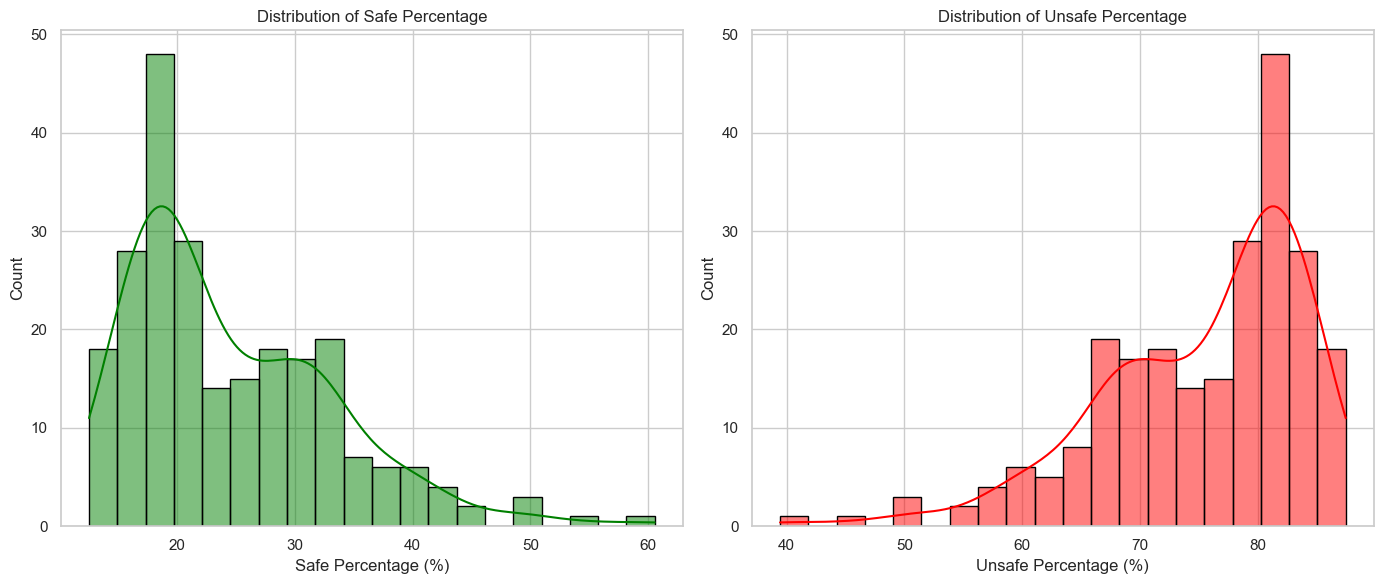

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style="whitegrid")

# Plot the distribution of safe and unsafe percentages
plt.figure(figsize=(14, 6))

# Safe Percentage Histogram
plt.subplot(1, 2, 1)
sns.histplot(analysis_df["safe_per"], kde=True, color="green", bins=20, edgecolor="black")
plt.title("Distribution of Safe Percentage")
plt.xlabel("Safe Percentage (%)")

# Unsafe Percentage Histogram
plt.subplot(1, 2, 2)
sns.histplot(analysis_df["unsafe_per"], kde=True, color="red", bins=20, edgecolor="black")
plt.title("Distribution of Unsafe Percentage")
plt.xlabel("Unsafe Percentage (%)")

plt.tight_layout()
plt.show()

- Safe Percentage: Most values are low, between 15% and 30%. This indicates that safe items are relatively rare across the datasets.
- Unsafe Percentage: Most values are high, between 65% and 85%. This suggests that unsafe items dominate in most datasets.
In short, the datasets are mostly unsafe, with only a small portion of items classified as safe.

## 3.b. Visualize Safe vs. Unsafe Percentages by Dataset
A bar plot comparing safe_per and unsafe_per for each dataset can show variations and help you easily identify datasets with extreme values.

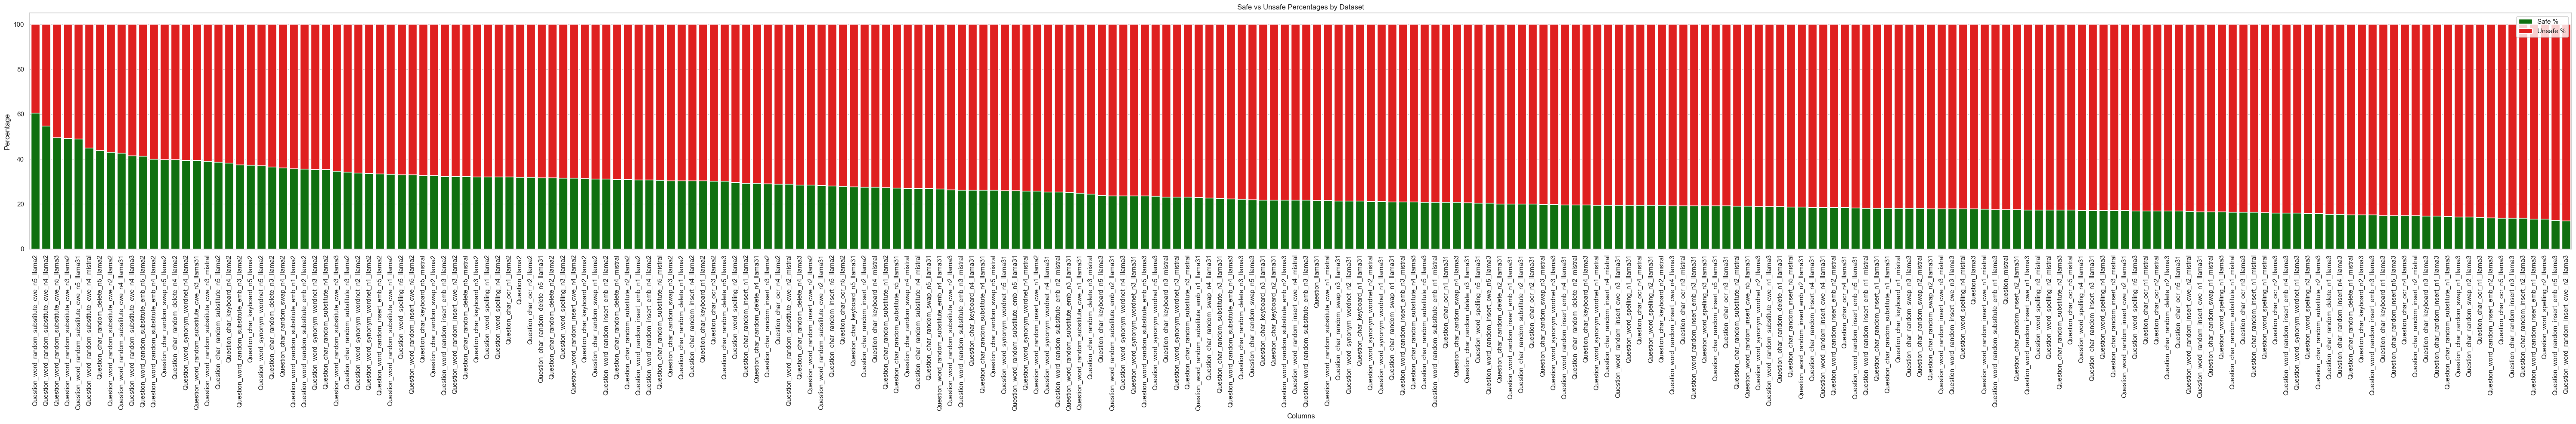

In [8]:
# Sort data for better visualization
sorted_data = analysis_df.sort_values(by="safe_per", ascending=False)

# Bar plot
plt.figure(figsize=(60, 10))
sns.barplot(x="columns", y="safe_per", data=sorted_data, color="green", label="Safe %")
sns.barplot(
    x="columns",
    y="unsafe_per",
    data=sorted_data,
    color="red",
    label="Unsafe %",
    bottom=sorted_data["safe_per"],
)

plt.xticks(rotation=90)
plt.xlabel("Columns")
plt.ylabel("Percentage")
plt.title("Safe vs Unsafe Percentages by Dataset")
plt.legend()
plt.tight_layout()
plt.show()

## 4. "safe" strongly negatively correlted with "unsafe"

 ## 4.a. Correlation Analysis with Heatmap

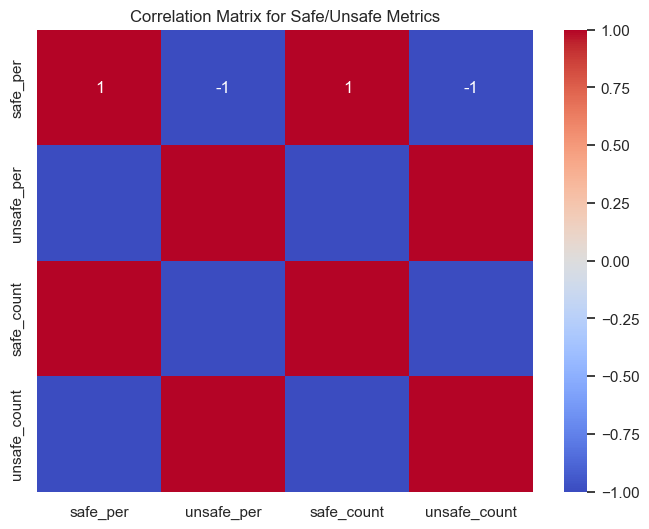

In [9]:
# Calculate the correlation matrix
correlation_matrix = analysis_df[['safe_per', 'unsafe_per', 'safe_count', 'unsafe_count']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix for Safe/Unsafe Metrics")
plt.show()


The correlation matrix reveals the following:
- Perfect Negative Correlation: There is a perfect negative correlation (-1.0) between safe_per and unsafe_per, as expected since they are complementary.
- Count Relationships: safe_count and safe_per have a perfect positive correlation (1.0), same with "unsafe" properties.

 ## 4.b. Cluster Analysis

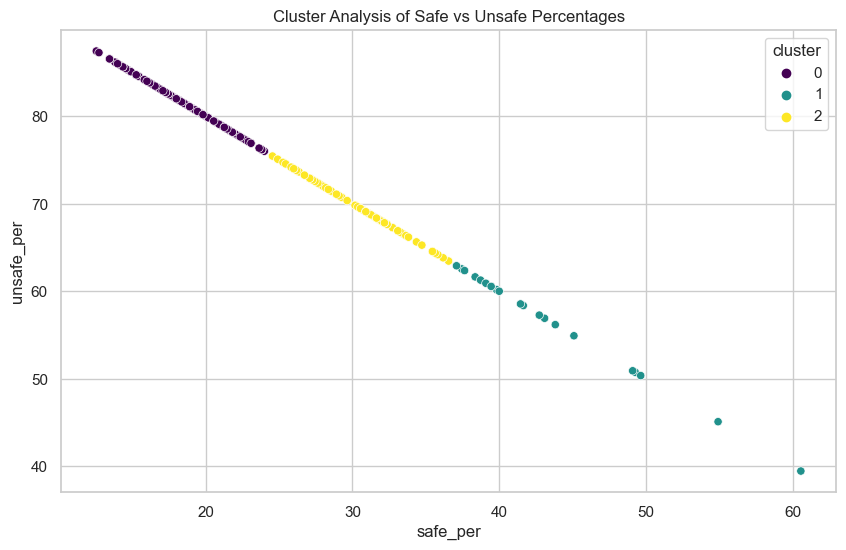

In [10]:
from sklearn.cluster import KMeans

# Prepare data for clustering
X = analysis_df[["safe_per", "unsafe_per"]]

# Define and fit the KMeans model
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
analysis_df["cluster"] = kmeans.labels_

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="safe_per", y="unsafe_per", hue="cluster", data=analysis_df, palette="viridis"
)
plt.title("Cluster Analysis of Safe vs Unsafe Percentages")
plt.show()

## 5. Identify Outliers

In [11]:
# Datasets with high safe percentage (>75%)
high_safe = analysis_df[analysis_df["safe_per"] > 75]

# Datasets with low safe percentage (<25%)
low_safe = analysis_df[analysis_df["safe_per"] < 25]

print("High Safe Percentage Datasets:")
display(high_safe)
print("Low Safe Percentage Datasets:")
display(low_safe)

High Safe Percentage Datasets:


,columns,safe_per,unsafe_per,safe_count,unsafe_count,cluster


Low Safe Percentage Datasets:


,columns,safe_per,unsafe_per,safe_count,unsafe_count,cluster
1,Question_char_keyboard_n1_llama3,14.91,85.09,82,468,0
2,Question_char_keyboard_n1_llama31,21.45,78.55,118,432,0
3,Question_char_keyboard_n1_mistral,18.18,81.82,100,450,0
5,Question_char_keyboard_n2_llama3,15.27,84.73,84,466,0
6,Question_char_keyboard_n2_llama31,21.82,78.18,120,430,0
...,...,...,...,...,...,...
226,Question_word_synonym_wordnet_n3_llama3,19.82,80.18,109,441,0
227,Question_word_synonym_wordnet_n3_llama31,23.82,76.18,131,419,0
228,Question_word_synonym_wordnet_n3_mistral,23.09,76.91,127,423,0
230,Question_word_synonym_wordnet_n4_llama3,23.82,76.18,131,419,0


## Naive vs Char vs Word Generation

In [20]:
# Filtering columns based on the naming patterns provided
char_columns = analysis_df[analysis_df["columns"].str.startswith("Question_char")]
word_columns = analysis_df[analysis_df["columns"].str.startswith("Question_word")]
naive_columns = analysis_df[
    ~analysis_df["columns"].str.startswith("Question_char")
    & ~analysis_df["columns"].str.startswith("Question_word")
]

In [32]:
# Extracting relevant statistics for further insights
# Calculating the overall mean, min, and max unsafe percentage for each type
naive_stats = naive_columns["unsafe_per"].describe()
char_stats = char_columns["unsafe_per"].describe()
word_stats = word_columns["unsafe_per"].describe()

# Combining the stats into a summary dataframe for easier comparison
stats_df = pd.DataFrame(
    {
        "Naive": naive_stats,
        "Character": char_stats,
        "Word": word_stats,
    }
).loc[["mean", "min", "max", "std", "25%", "50%", "75%"]]
stats_df

,Naive,Character,Word
mean,77.680000,76.565583,74.022946
min,68.000000,56.180000,39.450000
max,82.360000,86.180000,87.450000
std,6.701482,7.233496,9.811888
25%,75.770000,70.730000,67.775000
50%,80.180000,78.910000,77.000000
75%,82.090000,82.550000,81.450000


#### These statistics suggest that word-level perturbations have the widest range and variability, potentially reflecting a more diverse impact on safety compared to other methods.
- Range (Min - Max Unsafe %):
    - Naive: 68.00% - 82.36%
    - Character-level: 56.18% - 86.18%
    - Word-level: 39.45% - 87.45%
- Standard Deviation (indicating variability):
    - Naive: 6.70
    - Character-level: 7.23
    - Word-level: 9.81

## Distribution of unsafe percentages across these different types of generations
- **naive generations** are largely at or above 68% unsafe, indicating a generally high tendency toward unsafe content.
- **Character-level perturbed generation** shows a more spread-out distribution from around 55% to 86%, suggesting that character-level perturbations increase the unsafe score toward this upper range but also bring some variation.
- **Word-level perturbed generation** has the most extensive range, with unsafe percentages from as low as 39% up to 87%. This indicates that word-level perturbations have a broad impact on the unsafe score, ranging from very low to very high, showing a high degree of variability in safety impacts.

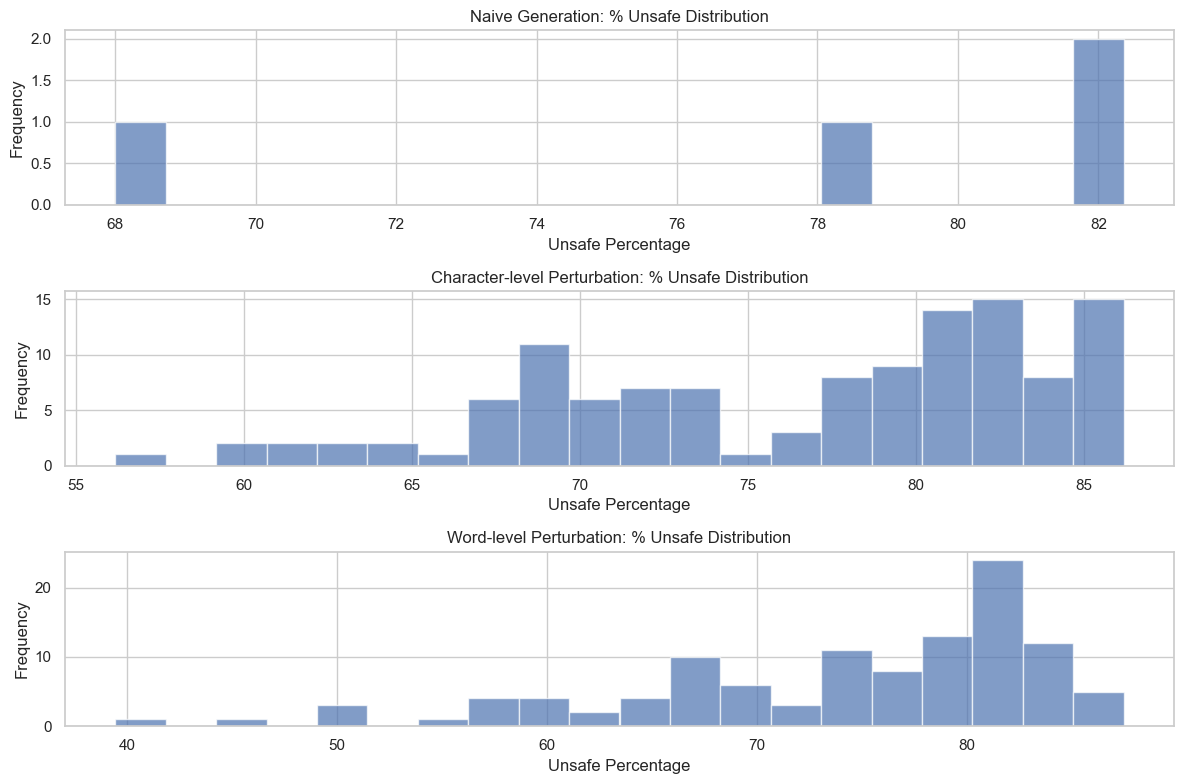

In [34]:
import matplotlib.pyplot as plt

# Plotting histograms for visual comparison of %unsafe across different perturbation types
plt.figure(figsize=(12, 8))

# Naive Generation histogram
plt.subplot(3, 1, 1)
plt.hist(naive_columns["unsafe_per"], bins=20, alpha=0.7)
plt.title("Naive Generation: % Unsafe Distribution")
plt.xlabel("Unsafe Percentage")
plt.ylabel("Frequency")

# Character-level Perturbation histogram
plt.subplot(3, 1, 2)
plt.hist(char_columns["unsafe_per"], bins=20, alpha=0.7)
plt.title("Character-level Perturbation: % Unsafe Distribution")
plt.xlabel("Unsafe Percentage")
plt.ylabel("Frequency")

# Word-level Perturbation histogram
plt.subplot(3, 1, 3)
plt.hist(word_columns["unsafe_per"], bins=20, alpha=0.7)
plt.title("Word-level Perturbation: % Unsafe Distribution")
plt.xlabel("Unsafe Percentage")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()